In [1]:
# Magics
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# Import libraries
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import optim
from torchvision import models, transforms
import path

from image_helpers import image_tensor_to_numpy,load_image_as_tensor
from layer_helpers import get_features, gram_matrix

In [3]:
# Import pre-trained model (No FC layers required)
vgg = models.vgg19(pretrained=True).features

# Freeze the layers of model
for layer in vgg.parameters():
    layer.requires_grad_(False)
    
# Move the model over to GPU
GPU = 'cuda'
vgg.to(GPU)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace)
  (18): MaxPool2d(kernel_size=2, stride=2, padding=0, 

In [4]:
# Load in the content and style images
content = load_image_as_tensor('pandas.jpg').to(GPU)

# Enuring that shape of style image same as content image
style = load_image_as_tensor('Edgar Degas.jpg', shape = content.shape[2:]).to(GPU) 

Text(0.5, 1.0, 'Style image')

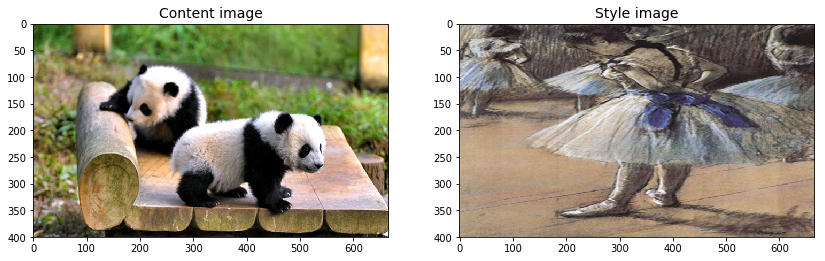

In [5]:
# Show the loaded images
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14,14))
ax1.imshow(image_tensor_to_numpy(content))
ax2.imshow(image_tensor_to_numpy(style))
ax1.set_title('Content image', fontsize=14)
ax2.set_title('Style image', fontsize=14)

In [6]:
# Get the feature maps for the content and style images
content_features = get_features(content, vgg)
style_features = get_features(style, vgg)

# Get gram matrices for the style feature maps
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

# Create the initial target image
target = content.clone().requires_grad_(True).to(GPU) 
# Note: We can start with a white noise image as target or with the content image
# We will iteratively change its style later

In [7]:
# Define the layer weights for the style loss
style_weights = {'conv1_1': 1,
                 'conv2_1': 0.8,
                 'conv3_1': 0.5,
                 'conv4_1': 0.2,
                 'conv5_1': 0.2}

# Define the weightage to be given to content and style losses
alpha = 1
beta = 1e5

Total loss: 175515.40625


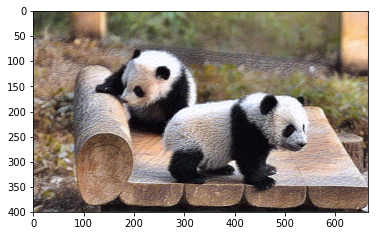

Total loss: 65947.203125


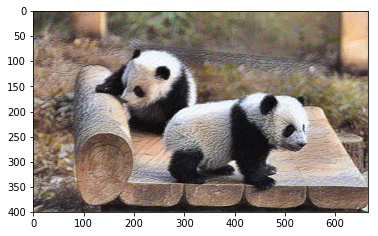

Total loss: 35672.765625


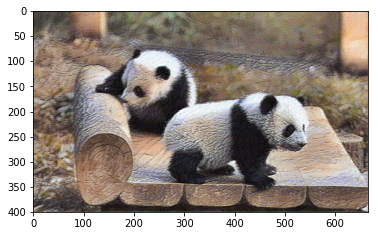

Total loss: 20927.375


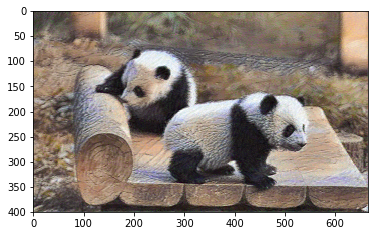

In [8]:
# Define hyperparameters
show_every = 500
steps = 2000
optimizer = optim.Adam([target], lr=0.003)

# Loop through the steps
for i in range(1, steps+1):
    
    # Get the target features
    target_features = get_features(target, vgg)
    # Calculate the content loss
    content_loss = torch.mean((target_features['conv4_2']-content_features['conv4_2'])**2)
    
    # Initialize style loss (start with 0 for every iteration)
    style_loss = 0
    
    # We need to loop through all style layers and calculate loss individually
    for layer in style_weights:
        # Get the target gram matrix for that layer
        target_feature = target_features[layer]
        target_gram = gram_matrix(target_feature)
        # Get the shape of the layer for normalization
        _, d, w, h = target_feature.shape
        
        # Get the style gram matrix for the layer
        style_gram = style_grams[layer]
        
        # Get the layer style loss
        layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
        
        # Add the layer loss / no. of values in layer (normalization) to the total style loss
        style_loss += layer_style_loss / (d*w*h)
        
    # Get the total loss
    total_loss = (alpha * content_loss) + (beta * style_loss)
    
    # Update the target image
    optimizer.zero_grad() 
    total_loss.backward()
    optimizer.step()
    
    # Show intermediate steps
    if i % show_every == 0:
        print('Total loss: {}'.format(total_loss))
        plt.imshow(image_tensor_to_numpy(target))
        plt.show()

Text(0.5, 1.0, 'Target image')

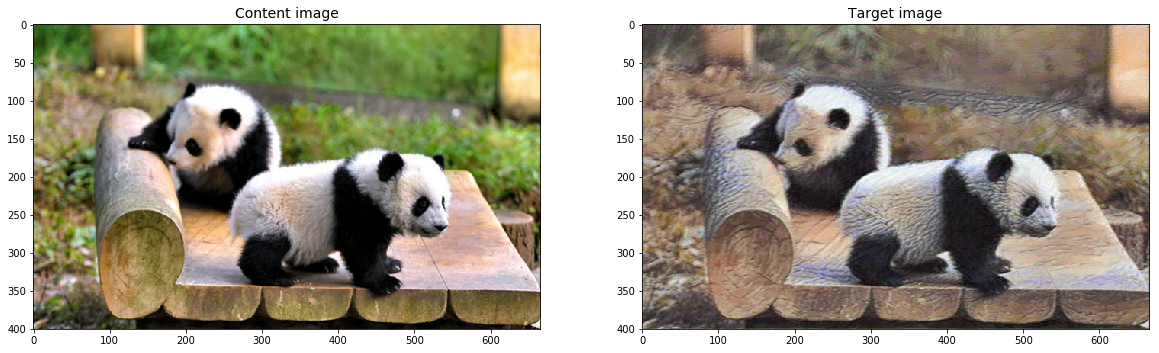

In [9]:
# display content and final, target image
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(image_tensor_to_numpy(content))
ax2.imshow(image_tensor_to_numpy(target))
ax1.set_title('Content image', fontsize=14)
ax2.set_title('Target image', fontsize=14)